# Trajectory Generation for a Particle

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyo
import pyomo.dae as dae

##  Parameters

In [2]:
# Set parameters
m=1        # Set mass of particle
g=9.81     # Set gravity
b=0.1      # Set drag coefficient
tf=12      # Set time for trajectory
dt=0.05     # Time step size

# Set the bounds on variables
x_min=0
x_max=6
y_min=0              
y_max=6             
u_x_max=5           # Input limit for vertical input
u_y_max=20          # Input limit for horizontal input
v_x_max=10          # Bounds for horizontal velocity 
v_y_max=10          # Bounds for vertical velocity 
a_x_max=10          # Bounds for horizontal acceleration
a_y_max=10          # Bounds for vertical acceleration

# Set initial and final values
x_init=0.5
y_init=0.5
v_x_init=0
v_y_init=0
x_fin=5
y_fin=5
v_x_fin=0
v_y_fin=0
a_x_fin=0
a_y_fin=0

# Obstacle location (circle)
r=1          # Radius of circle
cir_x=3      # X of center of circle
cir_y=3      # Y of center of circle

##  1. Minimize Input over Specified Time

In [3]:
# Create a model object
model=pyo.ConcreteModel()

# Define time 
model.t=dae.ContinuousSet(bounds=(0,tf))

# Define control inputs
model.u_x=pyo.Var(model.t)
model.u_y=pyo.Var(model.t)

# Define position and velocity (dependent variables)
model.x=pyo.Var(model.t)
model.y=pyo.Var(model.t)

# Define derivatives for position and velocity
model.v_x=dae.DerivativeVar(model.x,wrt=model.t)
model.v_y=dae.DerivativeVar(model.y,wrt=model.t)
model.a_x=dae.DerivativeVar(model.v_x,wrt=model.t)
model.a_y=dae.DerivativeVar(model.v_y,wrt=model.t)

# Define the initial conditions
model.con=pyo.ConstraintList()
model.con.add(model.x[0]==x_init)
model.con.add(model.y[0]==y_init)
model.con.add(model.v_x[0]==v_x_init)
model.con.add(model.v_y[0]==v_y_init)

# Define the final conditions
model.con.add(model.x[tf]==x_fin)
model.con.add(model.y[tf]==y_fin)
model.con.add(model.v_x[tf]==v_x_fin)
model.con.add(model.v_y[tf]==v_y_fin)
model.con.add(model.a_x[tf]==a_x_fin)
model.con.add(model.a_y[tf]==a_y_fin)

# Define the ODE
model.ode1=pyo.Constraint(model.t, rule=lambda model,t:model.a_x[t]==model.u_x[t]-b*model.v_x[t])
model.ode2=pyo.Constraint(model.t, rule=lambda model,t:model.a_y[t]==model.u_y[t]-g-b*model.v_y[t])

# Define the constraints
model.path_x1=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]>=x_min)
model.path_x2=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]<=x_max)
model.path_y1=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]>=y_min)
model.path_y2=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]<=y_max)
model.path_v_x1=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]>=-v_x_max)
model.path_v_x2=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]<=v_x_max)
model.path_v_y1=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]>=-v_y_max)
model.path_v_y2=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]<=v_y_max)
model.path_a_x1=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]>=-a_x_max)
model.path_a_x2=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]<=a_x_max)
model.path_a_y1=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]>=-a_y_max)
model.path_a_y2=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]<=a_y_max)

# Define the objective function (reduce the amount of control input used)
model.integral=dae.Integral(model.t,wrt=model.t,rule=lambda model,t: model.u_x[t]**2+model.u_y[t]**2)
model.obj=pyo.Objective(expr=model.integral)

# Perform discretization and solve
pyo.TransformationFactory('dae.finite_difference').apply_to(model,nfe=tf/dt,wrt=model.t)
pyo.SolverFactory("ipopt").solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4344, 'Number of variables': 1928, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.4817776679992676}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Plot Trajectories and Data

Objective function value: 1161.58


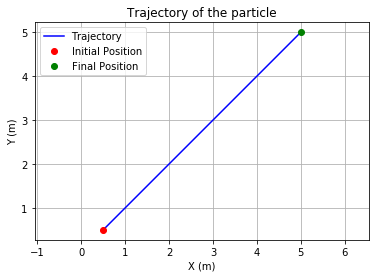

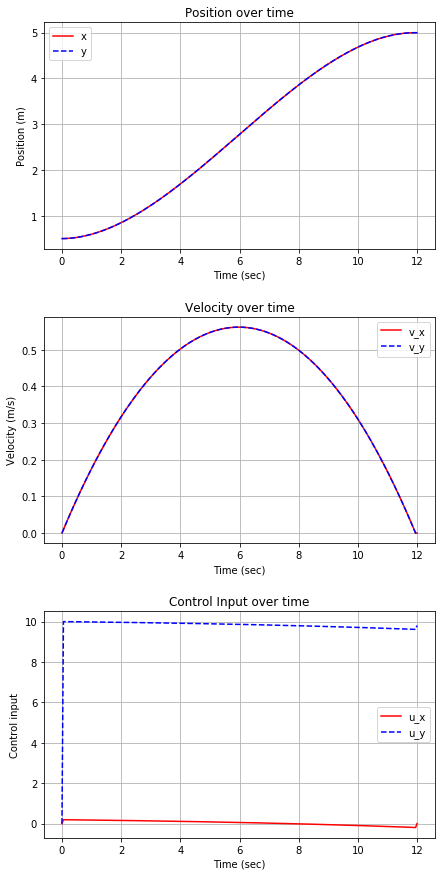

In [4]:
%matplotlib inline

# Access the variables
t=np.array([t for t in model.t])
x=np.array([model.x[t]() for t in model.t])
y=np.array([model.y[t]() for t in model.t])
v_x=np.array([model.v_x[t]() for t in model.t])
v_y=np.array([model.v_y[t]() for t in model.t])
u_x=np.array([model.u_x[t]() for t in model.t])
u_y=np.array([model.u_y[t]() for t in model.t])

print('Objective function value: '+ str(round(model.integral(),2)))

# Define function that plots all the data
def plot_data(t,x,y,v_x,v_y,u_x,u_y):
    fig,ax=plt.subplots(3,1,figsize=(7,15))
    fig.subplots_adjust(hspace=0.3)
    
    ax[0].plot(t,x,'r-',t,y,'b--')
    ax[0].legend(['x','y'])
    ax[0].set_ylabel("Position (m)")
    ax[0].set_title("Position over time")
    
    ax[1].plot(t,v_x,'r-',t,v_y,'b--')
    ax[1].legend(['v_x','v_y'])
    ax[1].set_ylabel("Velocity (m/s)")
    ax[1].set_title("Velocity over time")
    
    ax[2].plot(t,u_x,'r-',t,u_y,'b--')
    ax[2].legend(['u_x','u_y'])
    ax[2].set_ylabel("Control input")
    ax[2].set_title("Control Input over time")
    
    for axes in ax:
        axes.set_xlabel("Time (sec)")
        axes.grid(True)

# Plot the trajectory of the particle
plt.figure(1)
plt.plot(x,y,'b-')
plt.plot(x_init,y_init,'ro')
plt.plot(x_fin,y_fin,'go')
plt.title("Trajectory of the particle")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.axis('equal')
plt.grid(True)
plt.legend(['Trajectory','Initial Position','Final Position'])

# Plot the data
plot_data(t,x,y,v_x,v_y,u_x,u_y)


## 2. Minimize Input over Specified Time with Obstacle

In [5]:
# Trajectory with an obstacle

# Create a model object
model=pyo.ConcreteModel()

# Define time 
model.t=dae.ContinuousSet(bounds=(0,tf))

# Define control inputs
model.u_x=pyo.Var(model.t)
model.u_y=pyo.Var(model.t)

# Define position and velocity (dependent variables)
model.x=pyo.Var(model.t)
model.y=pyo.Var(model.t)

# Define derivatives for position and velocity
model.v_x=dae.DerivativeVar(model.x,wrt=model.t)
model.v_y=dae.DerivativeVar(model.y,wrt=model.t)
model.a_x=dae.DerivativeVar(model.v_x,wrt=model.t)
model.a_y=dae.DerivativeVar(model.v_y,wrt=model.t)

# Define the initial conditions
model.con=pyo.ConstraintList()
model.con.add(model.x[0]==x_init)
model.con.add(model.y[0]==y_init)
model.con.add(model.v_x[0]==v_x_init)
model.con.add(model.v_y[0]==v_y_init)

# Define the final conditions
model.con.add(model.x[tf]==x_fin)
model.con.add(model.y[tf]==y_fin)
model.con.add(model.v_x[tf]==v_x_fin)
model.con.add(model.v_y[tf]==v_y_fin)
model.con.add(model.a_x[tf]==a_x_fin)
model.con.add(model.a_y[tf]==a_y_fin)

# Define the ODE
model.ode1=pyo.Constraint(model.t, rule=lambda model,t:model.a_x[t]==model.u_x[t]-b*model.v_x[t])
model.ode2=pyo.Constraint(model.t, rule=lambda model,t:model.a_y[t]==model.u_y[t]-g-b*model.v_y[t])

# Define the constraints
model.path_x1=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]>=x_min)
model.path_x2=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]<=x_max)
model.path_y1=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]>=y_min)
model.path_y2=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]<=y_max)
model.path_v_x1=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]>=-v_x_max)
model.path_v_x2=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]<=v_x_max)
model.path_v_y1=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]>=-v_y_max)
model.path_v_y2=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]<=v_y_max)
model.path_a_x1=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]>=-a_x_max)
model.path_a_x2=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]<=a_x_max)
model.path_a_y1=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]>=-a_y_max)
model.path_a_y2=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]<=a_y_max)

# Define obstacle contraint
model.obs=pyo.Constraint(model.t,rule=lambda model,t: (model.x[t]-cir_x)**2+(model.y[t]-cir_y)**2>=r**2)

# Define the objective function (reduce the amount of control input used)
model.integral=dae.Integral(model.t,wrt=model.t,rule=lambda model,t: model.u_x[t]**2+model.u_y[t]**2)
model.obj=pyo.Objective(expr=model.integral)

# Perform discretization and solve
pyo.TransformationFactory('dae.finite_difference').apply_to(model,nfe=tf/dt,wrt=model.t)
pyo.SolverFactory("ipopt").solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4585, 'Number of variables': 1928, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 1.329178810119629}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Plot Trajectories and Data

Objective function value: 1161.7


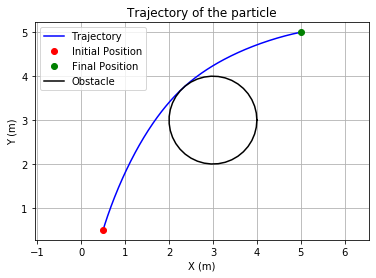

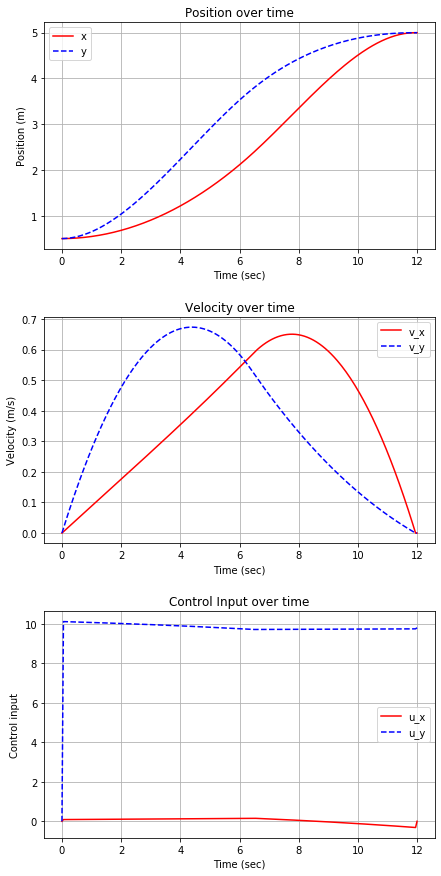

In [6]:
%matplotlib inline

# Calculate the circle outline
cir_theta=np.linspace(0,2*np.pi,40,endpoint=True)
circle_x=np.array(r*np.cos(cir_theta)+cir_x)
circle_y=np.array(r*np.sin(cir_theta)+cir_y)

# Access the variables
t=np.array([t for t in model.t])
x=np.array([model.x[t]() for t in model.t])
y=np.array([model.y[t]() for t in model.t])
v_x=np.array([model.v_x[t]() for t in model.t])
v_y=np.array([model.v_y[t]() for t in model.t])
u_x=np.array([model.u_x[t]() for t in model.t])
u_y=np.array([model.u_y[t]() for t in model.t])

print('Objective function value: '+ str(round(model.integral(),2)))

# Plot the trajectory of the particle
plt.figure(1)
plt.plot(x,y,'b-')
plt.plot(x_init,y_init,'ro')
plt.plot(x_fin,y_fin,'go')
plt.title("Trajectory of the particle")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.axis('equal')
plt.grid(True)
plt.plot(circle_x,circle_y,'k-')      # Plot when there is a circle obstacle
plt.legend(['Trajectory','Initial Position','Final Position','Obstacle'])

# Plot the data
plot_data(t,x,y,v_x,v_y,u_x,u_y)

## 3. Minimize Time 

In [7]:
# Minimum time trajectory

# Create a model object
model=pyo.ConcreteModel()

# Define time 
model.tf=pyo.Var(domain=pyo.NonNegativeReals)
model.t=dae.ContinuousSet(bounds=(0,1))

# Define control inputs
model.u_x=pyo.Var(model.t)
model.u_y=pyo.Var(model.t)

# Define position and velocity (dependent variables)
model.x=pyo.Var(model.t)
model.y=pyo.Var(model.t)

# Define derivatives for position and velocity
model.v_x=dae.DerivativeVar(model.x,wrt=model.t)
model.v_y=dae.DerivativeVar(model.y,wrt=model.t)
model.a_x=dae.DerivativeVar(model.v_x,wrt=model.t)
model.a_y=dae.DerivativeVar(model.v_y,wrt=model.t)

# Define the initial conditions
model.con=pyo.ConstraintList()
model.con.add(model.x[0]==x_init)
model.con.add(model.y[0]==y_init)
model.con.add(model.v_x[0]==v_x_init)
model.con.add(model.v_y[0]==v_y_init)

# Define the final conditions
model.con.add(model.x[1]==x_fin)
model.con.add(model.y[1]==y_fin)
model.con.add(model.v_x[1]==v_x_fin)
model.con.add(model.v_y[1]==v_y_fin)
model.con.add(model.a_x[1]==a_x_fin)
model.con.add(model.a_y[1]==a_y_fin)

# Define the ODE
model.ode1=pyo.Constraint(model.t, rule=lambda model,t:model.a_x[t]==model.u_x[t]-b*model.v_x[t])
model.ode2=pyo.Constraint(model.t, rule=lambda model,t:model.a_y[t]==model.u_y[t]-g-b*model.v_y[t])

# Define the constraints
model.path_x1=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]>=x_min)
model.path_x2=pyo.Constraint(model.t,rule=lambda model,t:model.x[t]<=x_max)
model.path_y1=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]>=y_min)
model.path_y2=pyo.Constraint(model.t,rule=lambda model,t:model.y[t]<=y_max)
model.path_v_x1=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]>=-model.tf*v_x_max)
model.path_v_x2=pyo.Constraint(model.t,rule=lambda model,t:model.v_x[t]<=model.tf*v_x_max)
model.path_v_y1=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]>=-model.tf*v_y_max)
model.path_v_y2=pyo.Constraint(model.t,rule=lambda model,t:model.v_y[t]<=model.tf*v_y_max)
model.path_a_x1=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]>=-model.tf**2*a_x_max)
model.path_a_x2=pyo.Constraint(model.t,rule=lambda model,t:model.a_x[t]<=model.tf**2*a_x_max)
model.path_a_y1=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]>=-model.tf**2*a_y_max)
model.path_a_y2=pyo.Constraint(model.t,rule=lambda model,t:model.a_y[t]<=model.tf**2*a_y_max)

# Define obstacle contraint
model.obs=pyo.Constraint(model.t,rule=lambda model,t: (model.x[t]-cir_x)**2+(model.y[t]-cir_y)**2>=r**2)

# Define the objective function (reduce the amount of control input used)
model.obj=pyo.Objective(expr=model.tf)

# Perform discretization and solve
pyo.TransformationFactory('dae.finite_difference').apply_to(model,nfe=tf/dt,wrt=model.t)
pyo.SolverFactory("ipopt").solve(model)

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 4585, 'Number of variables': 1929, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.11.1\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 9.922787427902222}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

Objective function value: 1.58


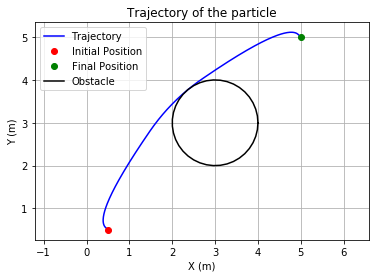

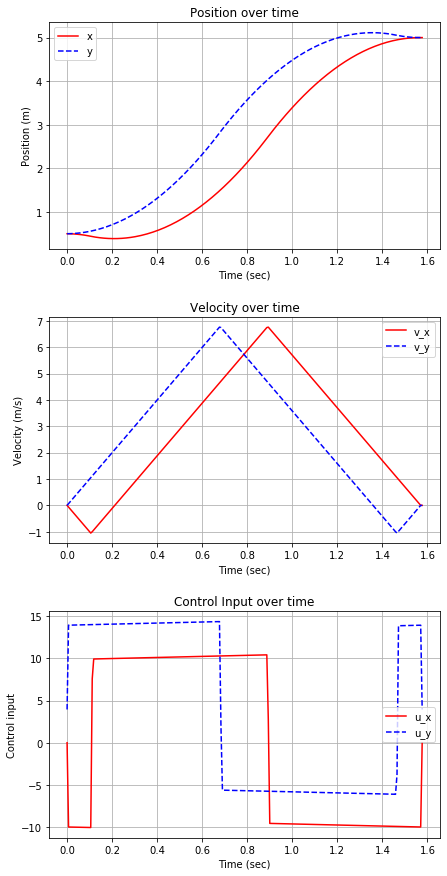

In [8]:
%matplotlib inline

# Calculate the circle outline
cir_theta=np.linspace(0,2*np.pi,40,endpoint=True)
circle_x=np.array(r*np.cos(cir_theta)+cir_x)
circle_y=np.array(r*np.sin(cir_theta)+cir_y)

# Access the variables
t=np.array([t*model.tf() for t in model.t])
x=np.array([model.x[t]() for t in model.t])
y=np.array([model.y[t]() for t in model.t])
v_x=np.array([model.v_x[t]()/model.tf() for t in model.t])
v_y=np.array([model.v_y[t]()/model.tf() for t in model.t])
a_x=np.array([model.a_x[t]()/model.tf()**2 for t in model.t])
a_y=np.array([model.a_y[t]()/model.tf()**2 for t in model.t])
u_x=np.array([model.u_x[t]()/model.tf()**2 for t in model.t])
u_y=np.array([model.u_y[t]()/model.tf()**2 for t in model.t])

print('Objective function value: '+ str(round(model.tf(),2)))

# Plot the trajectory of the particle
plt.figure(1)
plt.plot(x,y,'b-')
plt.plot(x_init,y_init,'ro')
plt.plot(x_fin,y_fin,'go')
plt.title("Trajectory of the particle")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.axis('equal')
plt.grid(True)
plt.plot(circle_x,circle_y,'k-')      # Plot when there is a circle obstacle
plt.legend(['Trajectory','Initial Position','Final Position','Obstacle'])

# Plot the data
plot_data(t,x,y,v_x,v_y,u_x,u_y)